In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as st

In [37]:
def choose_b(J_est):
    b = np.argmin(J_est)
    return b

def delta(k, b, mean):
    delta_ = np.zeros(k-1)
    j = 0
    for i in range(0,k):  
        if i == b :
            continue
        else:
            delta_[j] = mean[b] - mean[i]
            j = j + 1
    return delta_

def i_ind(i, b):
    # The index of best design b could 0 or 1, 2,.... 
    # So we should change the index of the first design in order to use the sample mean between the best design and the first design
    if i < b:
        index_i = i
    else:
        index_i = i - 1
    return index_i

def N_i_N_j(delta_ij, var_i_j):
    N_j = ((var_i_j[1] * (delta_ij[0] ** 2)) / (var_i_j[0] * (delta_ij[1] ** 2))) 
    return N_j

def N_b(k, b, N, var):
    sumN_b = 0
    for i in range(0, k):
        if i == b:
            continue
        sumN_b += (N[i] ** 2) / (var[i])
    N_b = math.sqrt(var[b] * sumN_b)
    return N_b

def initial_ratio(k, mean, var):
    b = choose_b(mean)
    delta_ = delta(k , b, mean)
    N = np.zeros(k)
    
    if b == 0:
        i = 1
    else:
        i = 0
    N[i] = 1             # In order to calculate the ratio, determine which is the first design and set it as 1
    
    for j in range(0, k):
        if j == b:
            continue
        if j == i:
            continue
        # Find the index of sample mean of N_i and N_j 
        delta_ij = [delta_[i_ind(i, b)], delta_[i_ind(j, b)]]
        var_i_j = [var[i], var[j]]
        # Since Ni : Nj : N(j+1) : N(j+2) = Ni/Ni : Nj/Ni : N(j+1)/Ni : N(j+2)/Ni
        # We can calculate (1) of THEOREM 1 
        N[j] = N_i_N_j(delta_ij, var_i_j)
        
    N[b] = N_b(k, b, N, var)
    ratio_sum = N.sum()
    prop = np.zeros(k)
    for i in range(0, k):
        prop[i] = N[i] / ratio_sum
    return prop

# Generate n_0 random number according to the N(mean, var) distribution
# Initialize
def Initialize_n_0_sim(mean, var, n = 5):
    random_sample = np.zeros((len(mean), n))
    for i in range(len(mean)):
        for j in range(n):
            random_sample[i][j] = np.random.normal(mean[i], (var[i] ** 0.5))
    return random_sample

def allocation_sim(mean, var, n):
    random_sample = np.zeros(n)
    for j in range(n):
        random_sample[j] = np.random.normal(mean, (var ** 0.5) )
    return random_sample

# Calculate the sample means and sample variances
def initial_mean_and_var(random_sample):
    mean_initial, var_initial = np.zeros(len(random_sample)), np.zeros(len(random_sample))
    # Generate new mean and new variance according to the simulation outputs(i.e., random_sample)
    for i in range(len(random_sample)):
        mean_initial[i] = np.mean(random_sample[i])
        var_initial[i] = np.var(random_sample[i])
    return mean_initial, var_initial

def update_mean_and_variance(mean_initial, var_initial, new_gen_mean, new_gen_var, n_0_sim, al_sim):
    mean_new = np.zeros(len(al_sim))
    for i in range(len(al_sim)):
        mean_new[i] = ((n_0_sim[i] * mean_initial[i]) + (al_sim[i] * new_gen_mean[i])) / (n_0_sim[i] + al_sim[i])    
    for j in range(len(al_sim)):
        var_new[j] = mean_new[j]

def APCS(k, N, mean, var):
    b = choose_b(mean)
    prob = np.zeros(k)
    mean_est = np.zeros(k)
    APCS_prob = 0
    for i in range(k):
        if i == b:
            continue
        else:
            mean_est[i] = mean[i] - mean[b]
            P_denominator = math.sqrt(var[b] / N[b] + var[i] / N[i])
            prob[i] = st.norm.cdf(mean_est[i] / P_denominator)  # P{J_b < J_i}  
    #print(mean_est)
    #print(prob)
    APCS_prob =  round(2 - k + prob.sum(),4)
        #print('negative',APCS_prob)
        #print('prob:', prob)
    return APCS_prob

def allocation(prob, tri_del):
    al_sim = np.zeros(k)
    for i in range(k):
        al_sim[i] = round(tri_del * prob[i]) # Convert float to integer
    if al_sim.sum() > tri_del:
        al_sim[np.argmax(al_sim)] = al_sim[np.argmax(al_sim)] - (al_sim.sum() - tri_del)
    return al_sim

def OCBA_method_PCS(k, mean, var, n_0, tri_del = 20, T = 5000):
    # Initialize
    sample = Initialize_n_0_sim(mean, var, n_0)
    mean_initial, var_initial = initial_mean_and_var(sample)
    current_completed = np.full(k, k * n_0)
    n_0_sims = np.full(k, n_0)
    add_max_sim = np.zeros(k)
    APCS_current = [APCS(k, n_0_sims, mean_initial, var_initial)]
    sample_store = [[]] * k
    total_sim = np.full(k, n_0)
    for i in range(k):
        sample_store[i] = [] 
    for i in range(k):
        sample_store[i].extend(list(sample[i]))
    total_budget = k * n_0
    while (total_budget <= T):
        total_budget += tri_del 
        probs = initial_ratio(k, mean_initial, var_initial)
        al_sim = allocation(probs, total_budget)
        al_sim = np.array(al_sim,dtype=np.int)
        mean_new, var_new = np.zeros(k), np.zeros(k)
#         print('initial_n_0_sim', n_0_sims)
#         print('mean_initial', mean_initial)
#         print('allocation_simulation :', al_sim)
        for i in range(k):
            add_max_sim[i] = np.maximum(al_sim[i] - n_0_sims[i], 0)
            #print(add_max_sim[i])
        to_do = np.where(add_max_sim > 0)
        for i in to_do[0]:
            new_gen = allocation_sim(mean_initial[i], var_initial[i], int(add_max_sim[i]))
            sample_store[i].extend(list(new_gen))
            mean_new[i] = np.mean(sample_store[i])
            var_new[i] = np.var(sample_store[i])
            n_0_sims[i] = al_sim[i]
        #print('n_0: ',n_0_sims)
        #print('need to sim:',add_max_sim)
        to_not_do = np.where(add_max_sim  == 0)
        for m in to_not_do[0]:
            mean_new[m] = mean_initial[m]
            var_new[m] = var_initial[m]
            n_0_sims[m] = n_0_sims[m]
        #print(mean_initial, var_initial)
        #print(mean_new, var_new)
        #print('L:',n_0_sims)
        mean_initial = mean_new
       # print('mean', mean_initial)
        var_initial = var_new
        total_sim += al_sim
        APCS_P = APCS(k, total_sim, mean_initial, var_initial)
        APCS_current.append(APCS_P)
        total_budget += tri_del
        #print(total_budget)
    b_est = choose_b(mean_initial)
    b_actual = 0
    if b_est == b_actual:
        return APCS_P
    else:
        return 0
    #print(APCS_current)
    #x = np.linspace(k*n_0, T, len(APCS_current))
    #plt.plot(x, APCS_current)

In [18]:
np.random.normal(1,6,5)

array([ 0.20747677,  2.49073475, -5.75791075,  7.76021867,  2.17381745])

In [58]:
n_0 = 5
k = 5
mean = range(k)
var = np.ones(k) * 36
avg_pcs = np.zeros(100)
n_0_equal_5 = np.zeros(40)
for i in range(100):
    for t in range(40):
        n_0_equal_5[t] = OCBA_method_PCS(k, mean, var, n_0 , tri_del = 20,T = 25+i*20)
    #print(n_0_equal_5, '\n')
    avg_pcs[i] = n_0_equal_5.mean()
    #print('avege', avg_pcs[i])
print(avg_pcs)

KeyboardInterrupt: 

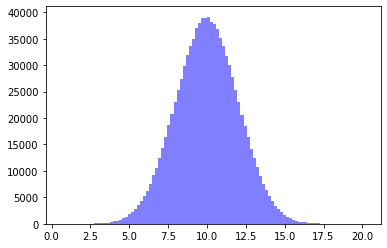

In [463]:
mean = [1, 2, 3, 4, 5]
var = [36, 36, 36, 36, 36]
a =np.random.normal(mean[0], (var[0] ** 0.5) / 5, 1000000)
b= np.random.normal(10, 2, 1000000)
num_bins = 100
n, bins, patches = plt.hist(b, num_bins, facecolor='blue', alpha=0.5)  

In [27]:
k = 5
n_0 = 5
mean = [1, 2, 3, 4, 5]
var = [36, 36, 36, 36, 36]
mean_initial, var_initial = np.zeros(k), np.zeros(k)
sample = np.zeros([len(mean), n_0])
sample = Initialize_n_0_sim(mean, var, n_0)
print(sample)
sample_store1, sample_store2, sample_store3, sample_store4, sample_store5 = [],[],[],[],[]
sample_s = [sample_store1, sample_store2, sample_store3, sample_store4, sample_store5]
for i in range(k):
    sample_s[i].extend(list(sample[i]))
    
print(np.var(sample_s[1]))
sample_s[1].extend(list(mean))
q = np.var(sample_s[1])
q

[[-0.34440834  4.43406527  9.13987258  1.19854388 -5.44809098]
 [-8.56640534 -0.33096837  2.76396144  0.48771718  2.3742633 ]
 [ 7.62379522  0.32075463  2.99380851 -4.65914057 16.06505786]
 [-0.35303055 12.54675502  4.55347282 11.48761033  1.70597336]
 [ 5.89131137 12.6235089  -2.28675334 10.17365844  0.37589577]]
16.97337289844801


12.825138644033785

In [1266]:
mean = [1, 2, 3, 4, 5]
var = [36, 36, 36, 36, 36]
var_n = np.zeros(5)
sample_store1, sample_store2, sample_store3, sample_store4, sample_store5 = [], [], [],[],[]
sample_s = [sample_store1, sample_store2, sample_store3, sample_store4, sample_store5]
sample = list(Initialize_n_0_sim(mean, var, n_0))
for i in range(5):
    print('1',sample[i])
    sample_s[i].extend(list(sample[i]))
    print('1',sample_s[i])
    var_n[i] = np.mean(sample_s[i])

for j in range(5):
    print(sample[j])
    sample_s[j].extend(list(sample[j]))
    print(sample_s[j])
    var_n[j] = np.mean(sample_s[j])
var_n

1 [ 3.72325799 -3.67411966  1.96258853 -1.3168394   3.97864324]
1 [3.7232579928119267, -3.674119655627128, 1.9625885303469814, -1.3168393956172952, 3.978643244394504]
1 [ 5.00648801  4.15281387 -4.46424668  7.31277839  6.01785934]
1 [5.006488005796459, 4.152813870679915, -4.464246679008483, 7.3127783851697385, 6.017859344353436]
1 [-6.25508945  0.48515496 -8.17602596 -6.61426634 -0.14089261]
1 [-6.255089448986151, 0.4851549572510714, -8.176025961484623, -6.614266343474462, -0.1408926060090696]
1 [ 1.94519028  5.61491574  3.82862043  8.19218245 -1.03659791]
1 [1.9451902835274857, 5.614915737823486, 3.828620434481145, 8.192182451710675, -1.0365979094155637]
1 [0.81160807 6.54110741 8.32122    2.34101382 2.24707388]
1 [0.811608069901367, 6.541107407324136, 8.321219997109626, 2.341013817369409, 2.2470738812595603]
[ 3.72325799 -3.67411966  1.96258853 -1.3168394   3.97864324]
[3.7232579928119267, -3.674119655627128, 1.9625885303469814, -1.3168393956172952, 3.978643244394504, 3.7232579928119

array([ 0.93470614,  3.60513859, -4.14022388,  3.7088622 ,  4.05240463])

In [1156]:
mean = [1, 2, 3, 4, 5]
var = [36, 36, 36, 36, 36]
sample = Initialize_n_0_sim(mean, var, n = 100000)
initial_mean_and_var(sample)

(array([1.01483535, 1.96312858, 3.00130742, 4.01395473, 5.01451646]),
 array([36.07431722, 36.3094208 , 36.16559082, 35.81471304, 36.06246247]))

In [1219]:
al_sim = [8, 2, 3, 5, 2]
mean_new = np.zeros(5)
sample_store1, sample_store2, sample_store3, sample_store4, sample_store5 = [], [], [],[],[]
sample_s = [sample_store1, sample_store2, sample_store3, sample_store4, sample_store5]
for i in range(len(mean)):
    sample = allocation_sim(mean[i], var[i], al_sim[i])
    sample_s[i].append(sample)
    mean_new[i] = np.mean(sample_s[i])
    

In [1186]:
sample_store1, sample_store2, sample_store3, sample_store4, sample_store5 = [], [], [],[],[]

In [1187]:
sample_s = [sample_store1, sample_store2, sample_store3, sample_store4, sample_store5]

In [62]:
a1 = list(np.array([1,2]))
a2 = [2,3,4]
a3 = [1,5,5,4,3,3]

In [53]:
s_mean = [1.2,2.1,3.4,4.87,6.05]
s_var= [3.3,2,4.5,5.3,6.9]
n_0 = [12, 6, 5, 5, 4]
k = 5
morerun = np.ones(5)
add_ = np.zeros(k)
add_budget = 100
t_budget = add_budget
t1_budget = t_budget
def second_best(mean, k, b):
    if b == 0:
        second_index = 1
    else:
        second_index = 0 
    for i in range(k):
        if mean[i] < mean[second_index] and i != b:
            second_index = 1
    return second_index
ratio = np.zeros(k)
b = choose_b(s_mean)
s = second_best(s_mean,k, b)
ratio[s] = 1
for i in range(k):
    if i != s and i !=b:
        temp = (s_mean[b] - s_mean[s])/(s_mean[b] - s_mean[i])
        ratio[i] = temp * temp * s_var[i] / s_var[s]
    temp = 0
    for i in range(k):
        if(i != b):
            temp += (ratio[i] * ratio[i] / s_var[i])
            ratio[b] = math.sqrt(s_var[b] * temp)
more_alloc = 1
while(more_alloc):
    more_alloc = 0
    ratio_s = 0
    for i in range(k):
        if(morerun[i]):
            ratio_s += ratio[i]
    for i in range(k):
        if(morerun[i]):
            add_[i] = t1_budget/ ratio_s * ratio[i]
            print(add_[i])
            if(add_[i] < n_0[i]):
                add_[i] = n_0[i]
                morerun[i] = 0
                more_alloc = 1
    if(more_alloc):
        t1_budget = t_budget
        for i in range(k):
            if(morerun[i] == 0):
                t1_budget -= add_[i]
    if(more_alloc == 0):
        break
t1_budget = add_[0]
for i in range(k):
    t1_budget += add_[i]
add_[b] += (t_budget - t1_budget)
for i in range(k):
    add_[i] -= n_0[i]
    
add_

44.61358605916089
33.471817141367595
12.603798913252573
5.334307589628371
3.9764902965905744
44.6026631905892
33.46362214312186
12.600713090049505
5.333001576239418


array([-12.        ,  27.46362214,   7.60071309,   0.33300158,
         0.        ])

In [392]:
s_mean = [1.2, 2.1, 3.4, 4.87, 6.05]
s_var= [3.3, 2.0, 4.5, 5.3, 6.9]
#s_mean = [1,2,3,4,5]
#s_var = [1,1,9,9,4]
t1_budget = 100
prob = initial_ratio(k, s_mean, s_var)
an = allocation(prob, t1_budget)
k = 5

[1.33287015 1.         0.37654959 0.15936713 0.11880115]


In [408]:
def second_best(mean, k, b):
    if b == 0:
        second_index = 1
    else:
        second_index = 0 
    for i in range(k):
        if mean[i] < mean[second_index] and i != b:
            second_index = 1
    return second_index
ratio = np.zeros(k)
b = choose_b(s_mean)
s = second_best(s_mean,k, b)
ratio[s] = 1
for i in range(k):
    if i != s and i !=b:
        temp = (mean[b] - mean[s])/(mean[b] - mean[i])
        print(mean[b], mean[s], mean[i])
        ratio[i] = temp * temp * s_var[i] / s_var[s]
    temp = 0
    for i in range(k):
        if(i != b):
            temp += (ratio[i] * ratio[i] / s_var[i])
            ratio[b] = math.sqrt(s_var[b] * temp)
ratio

0 1 2
0 1 3
0 1 4


array([1.39937452, 1.        , 0.5625    , 0.29444444, 0.215625  ])

In [459]:
J_est = mean
np.argmin(J_est)

0